# 01 - Data Retrieval (V1)

This notebook retrieves historical price data and financial statements for publicly traded companies listed in the S&P 500 index. The data includes:

- Basic company metadata
- Daily historical price data (adjusted and unadjusted)
- Annual and quarterly financial statements (balance sheet, income statement, cash flow)

To avoid exceeding API rate limits, this version focuses on retrieving data for a single company at a time.

In [ ]:
# Import necessary libraries
import os
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

from config import API_KEY

In [146]:
# Suppress all warnings
warnings.filterwarnings('ignore')

## 1. S&P 500 Index Constituents

The S&P 500 is a stock market index that tracks the performance of 500 large-cap companies listed on U.S. stock exchanges. It is widely regarded as one of the best representations of the U.S. equity market.

The dataset used here, `S&P_500_Companies.csv`, contains the following fields for each constituent:
- Ticker symbol
- Company name
- Sector classification
- Sub-industry classification

This section loads and displays the dataset to provide visibility into the available companies for analysis.

In [147]:
# Load the S&P 500 company list
sp500 = pd.read_csv("S&P_500_Companies.csv")

In [148]:
# Preview few entries
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services
...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment
501,ZION,Zions Bancorporation,Financials,Regional Banks


## 2. Stock Selection

To retrieve market and financial data, a valid stock ticker must be specified. This symbol will be used to initialize the data retrieval object.

The example below uses Apple Inc. (`AAPL`) as the target company.

In [149]:
# Define the stock ticker symbol
stock = "PG"

In [150]:
# Initialize the Ticker object using yfinance
ticker = yf.Ticker(stock)

## 3. Company Overview (Optional)

Basic metadata about the selected company is retrieved using the Alpha Vantage API. Although this information is not used in the current model pipeline, it is collected for potential future applications, such as mobile app integration or informational dashboards.

The metadata includes:
- Name, description, and industry
- Market capitalization
- Financial ratios and performance metrics
- Company location and official website

In [151]:
# Retrieve company overview from Alpha Vantage
url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={stock}&apikey={API_KEY}'
r = requests.get(url)
overview = r.json()

In [152]:
# Display the raw JSON
overview

{'Symbol': 'PG',
 'AssetType': 'Common Stock',
 'Name': 'Procter & Gamble Company',
 'Description': "The Procter & Gamble Company (P&G) is an American multinational consumer goods corporation headquartered in Cincinnati, Ohio, founded in 1837 by William Procter and James Gamble. It specializes in a wide range of personal health, consumer health, personal care, and hygiene products; these products are organized into several segments including Beauty; Grooming; Health Care; Fabric & Home Care; and Baby, Feminine, & Family Care. Before the sale of Pringles to Kellogg's, its product portfolio also included food, snacks, and beverages.",
 'CIK': '80424',
 'Exchange': 'NYSE',
 'Currency': 'USD',
 'Country': 'USA',
 'Sector': 'LIFE SCIENCES',
 'Industry': 'SOAP, DETERGENTS, CLEANG PREPARATIONS, PERFUMES, COSMETICS',
 'Address': 'ONE PROCTER & GAMBLE PLAZA, CINCINNATI, OH, US',
 'OfficialSite': 'https://www.pginvestor.com',
 'FiscalYearEnd': 'June',
 'LatestQuarter': '2025-03-31',
 'MarketCapi

## 4. Historical Price Data

Two forms of historical price data are collected for the selected stock:

- **Raw (Unadjusted) Daily Prices:** Retrieved from Alpha Vantage. Represents the stock price as it was reported on each trading day, without adjustments for dividends or splits.
  
- **Adjusted Daily Prices:** Retrieved from Yahoo Finance via `yfinance`. Adjusted prices reflect dividend payouts and stock splits, making them suitable for modeling total returns over time.

Each dataset is processed into a structured and typed DataFrame, ready for downstream analysis.


### 4.1 Raw (Unadjusted) Historical Price Data

Unadjusted price data is retrieved via the `TIME_SERIES_DAILY` function from Alpha Vantage. The data includes:

- Open, high, low, close prices
- Trading volume

The JSON response is transformed into a clean, typed DataFrame, indexed by date.

In [153]:
def process_raw_price_data(raw_json):
    """
    Cleans Alpha Vantage TIME_SERIES_DAILY stock price JSON.
    - Converts to DataFrame
    - Parses and sorts datetime index
    - Renames columns to `*_raw`
    - Converts data types for numerical analysis
    Returns:
    - A cleaned DataFrame with 'Date' as index.
    """
    df = pd.DataFrame(raw_json["Time Series (Daily)"]).T
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
    df.index.name = 'Date'
    df.sort_index(inplace=True)

    df.rename(columns={
        "1. open": "open_raw",
        "2. high": "high_raw",
        "3. low": "low_raw",
        "4. close": "close_raw",
        "5. volume": "volume_raw"
    }, inplace=True)

    df = df.astype({
        "open_raw": float,
        "high_raw": float,
        "low_raw": float,
        "close_raw": float,
        "volume_raw": int
    })

    return df

In [154]:
# Fetch raw historical price data from Alpha Vantage
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&outputsize=full&apikey={API_KEY}'
r = requests.get(url)
history_raw = r.json()

In [155]:
# Display a sample of the original JSON
history_raw

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'PG',
  '3. Last Refreshed': '2025-05-16',
  '4. Output Size': 'Full size',
  '5. Time Zone': 'US/Eastern'},
 'Time Series (Daily)': {'2025-05-16': {'1. open': '162.6500',
   '2. high': '163.4300',
   '3. low': '161.8500',
   '4. close': '163.2800',
   '5. volume': '7068005'},
  '2025-05-15': {'1. open': '159.5900',
   '2. high': '162.9080',
   '3. low': '158.7000',
   '4. close': '162.4100',
   '5. volume': '8727316'},
  '2025-05-14': {'1. open': '158.1200',
   '2. high': '159.1600',
   '3. low': '157.5700',
   '4. close': '158.0200',
   '5. volume': '5988905'},
  '2025-05-13': {'1. open': '160.0200',
   '2. high': '160.7200',
   '3. low': '157.3600',
   '4. close': '158.7300',
   '5. volume': '7780827'},
  '2025-05-12': {'1. open': '157.4250',
   '2. high': '161.0500',
   '3. low': '156.6900',
   '4. close': '160.9000',
   '5. volume': '7378380'},
  '2025-05-09': {'1. open': '158.0200

In [156]:
# Process the raw data into a structured DataFrame
history_raw = process_raw_price_data(history_raw)

The final DataFrame contains:
- Five columns: `open_raw`, `high_raw`, `low_raw`, `close_raw`, `volume_raw`
- DateTime index sorted in chronological order
- Appropriate numeric types for modeling

In [157]:
# Preview the cleaned DataFrame
history_raw

,open_raw,high_raw,low_raw,close_raw,volume_raw
Date,,,,,
1999-11-01,105.100,108.600,104.90,108.00,2810500
1999-11-02,107.800,108.400,106.00,106.00,2550100
1999-11-03,106.600,107.600,105.30,106.80,2503300
1999-11-04,107.300,107.400,104.00,105.30,2124000
1999-11-05,106.000,106.800,105.50,105.90,1653100
...,...,...,...,...,...
2025-05-12,157.425,161.050,156.69,160.90,7378380
2025-05-13,160.020,160.720,157.36,158.73,7780827
2025-05-14,158.120,159.160,157.57,158.02,5988905


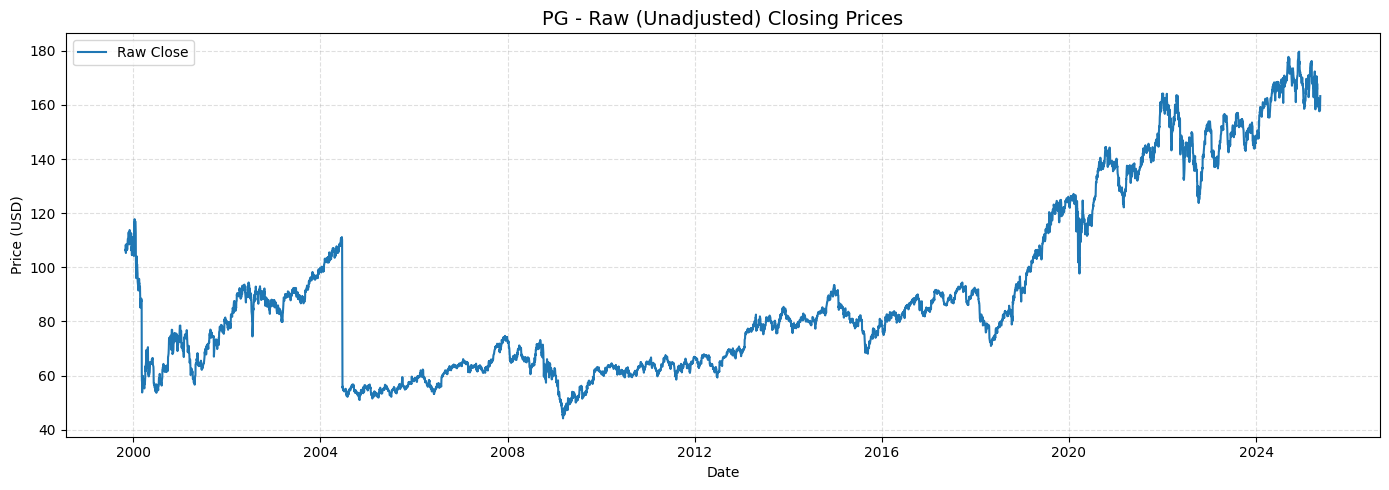

In [158]:
# Plot the raw closing prices
plt.figure(figsize=(14, 5))
plt.plot(history_raw.index, history_raw['close_raw'], label='Raw Close', color='tab:blue')
plt.title(f"{stock} - Raw (Unadjusted) Closing Prices", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


In [159]:
# Summary of data structure and types
history_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6425 entries, 1999-11-01 to 2025-05-16
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open_raw    6425 non-null   float64
 1   high_raw    6425 non-null   float64
 2   low_raw     6425 non-null   float64
 3   close_raw   6425 non-null   float64
 4   volume_raw  6425 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 301.2 KB


### 4.2 Adjusted Historical Price Data

Adjusted price data is retrieved from Yahoo Finance using the `yfinance` library. These prices are adjusted for corporate actions such as dividends and stock splits, providing a more accurate representation of a stock's total return over time.

This dataset includes:
- Adjusted open, high, low, close prices
- Adjusted trading volume
- Dividend payouts and stock split history

The data is retrieved using `ticker.history()` and processed into a structured DataFrame suitable for modeling.

In [160]:
def process_adjusted_price_data(df):
    """
    Cleans adjusted stock price DataFrame (e.g., from yfinance `ticker.history()`).
    - Localizes datetime index to naive UTC
    - Renames columns to *_adj
    - Sets proper data types
    Returns:
    - Cleaned and typed DataFrame with 'Date' as index.
    """
    df = df.copy()
    df.index = df.index.tz_localize(None)
    df.index.name = 'Date'

    df.rename(columns={
        'Open': 'open_adj',
        'High': 'high_adj',
        'Low': 'low_adj',
        'Close': 'close_adj',
        'Volume': 'volume_adj',
        'Dividends': 'dividends',
        'Stock Splits': 'stock_splits'
    }, inplace=True)

    df = df.astype({
        'open_adj': float,
        'high_adj': float,
        'low_adj': float,
        'close_adj': float,
        'volume_adj': int,
        'dividends': float,
        'stock_splits': float
    })

    return df


In [161]:
# Fetch 25 years of adjusted price data including dividends and stock splits
history_adj = ticker.history(period='25y', actions=True)

In [162]:
# Display the retrieved DataFrame
history_adj

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-05-17 00:00:00-04:00,16.609785,16.738543,16.416648,16.738543,6044400,0.0,0.0
2000-05-18 00:00:00-04:00,16.674160,16.819013,16.609781,16.674160,5166400,0.0,0.0
2000-05-19 00:00:00-04:00,16.545401,16.786822,16.497117,16.754633,5963800,0.0,0.0
2000-05-22 00:00:00-04:00,16.786816,16.835101,16.561490,16.706343,6186200,0.0,0.0
2000-05-23 00:00:00-04:00,16.577589,16.786821,16.416642,16.577589,5295400,0.0,0.0
...,...,...,...,...,...,...,...
2025-05-12 00:00:00-04:00,157.429993,161.050003,156.690002,160.899994,7378400,0.0,0.0
2025-05-13 00:00:00-04:00,160.020004,160.720001,157.360001,158.729996,7780800,0.0,0.0
2025-05-14 00:00:00-04:00,158.119995,159.160004,157.570007,158.020004,5988900,0.0,0.0


In [163]:
# Process the adjusted data
history_adj = process_adjusted_price_data(history_adj)

The final DataFrame contains:
- Five columns: `open_adj`, `high_adj`, `low_adj`, `close_adj`, `volume_adj`
- Additional columns for `dividends` and `stock_splits`
- DateTime index sorted in chronological order
- Appropriate numeric types for modeling

In [164]:
# Preview the cleaned adjusted DataFrame
history_adj

,open_adj,high_adj,low_adj,close_adj,volume_adj,dividends,stock_splits
Date,,,,,,,
2000-05-17,16.609785,16.738543,16.416648,16.738543,6044400,0.0,0.0
2000-05-18,16.674160,16.819013,16.609781,16.674160,5166400,0.0,0.0
2000-05-19,16.545401,16.786822,16.497117,16.754633,5963800,0.0,0.0
2000-05-22,16.786816,16.835101,16.561490,16.706343,6186200,0.0,0.0
2000-05-23,16.577589,16.786821,16.416642,16.577589,5295400,0.0,0.0
...,...,...,...,...,...,...,...
2025-05-12,157.429993,161.050003,156.690002,160.899994,7378400,0.0,0.0
2025-05-13,160.020004,160.720001,157.360001,158.729996,7780800,0.0,0.0
2025-05-14,158.119995,159.160004,157.570007,158.020004,5988900,0.0,0.0


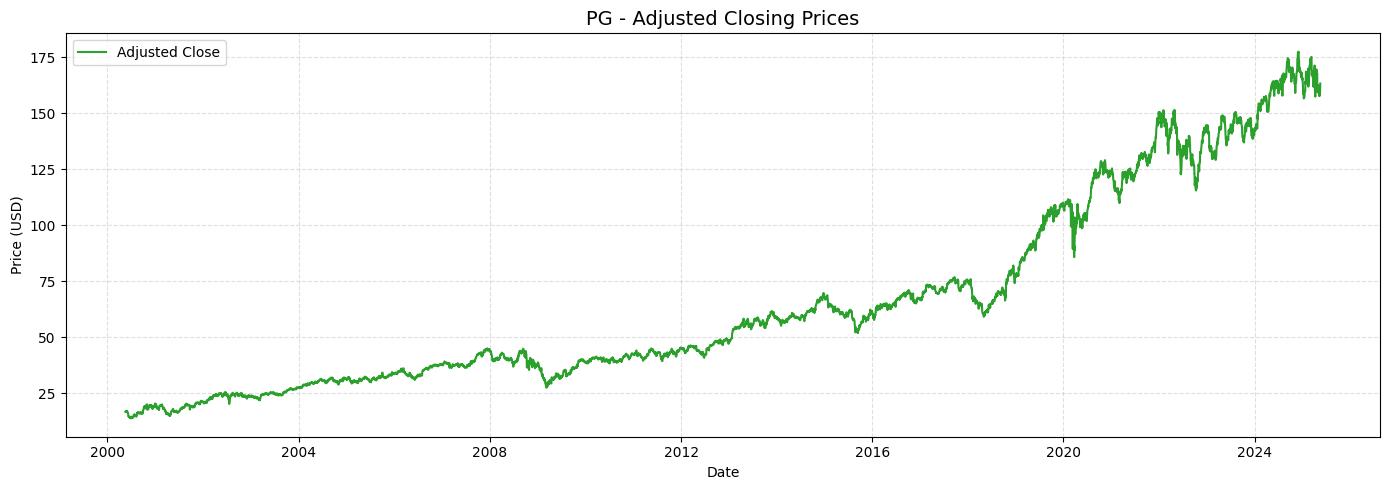

In [165]:
# Plot the adj closing prices
plt.figure(figsize=(14, 5))
plt.plot(history_adj.index, history_adj['close_adj'], label='Adjusted Close', color='tab:green')
plt.title(f"{stock} - Adjusted Closing Prices", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [166]:
# Summary of data structure and types
history_adj.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6288 entries, 2000-05-17 to 2025-05-16
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open_adj      6288 non-null   float64
 1   high_adj      6288 non-null   float64
 2   low_adj       6288 non-null   float64
 3   close_adj     6288 non-null   float64
 4   volume_adj    6288 non-null   int64  
 5   dividends     6288 non-null   float64
 6   stock_splits  6288 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 393.0 KB


## 5. Financial Statements

Financial statements are structured reports that provide a comprehensive view of a company's financial performance and position. These statements are essential for evaluating a firm’s profitability, solvency, liquidity, and cash generation.

This section retrieves and processes **annual** and **quarterly** financial statements from Alpha Vantage. Each report is returned as raw JSON and converted into a clean, time-indexed DataFrame suitable for financial analysis or machine learning.

The three core financial statements included are:

1. **Balance Sheet** – Snapshot of the company's financial position at a specific point in time.
2. **Income Statement** – Summary of revenues, expenses, and profits over a reporting period.
3. **Cash Flow Statement** – Records the inflows and outflows of cash from operations, investing, and financing.

The processed data is sorted chronologically and converted to appropriate numeric types to preserve data fidelity.

In [167]:
def process_financial_report(raw_json, report_type):
    """
    Converts a raw financial report JSON (from Alpha Vantage) into a cleaned, 
    time-indexed DataFrame suitable for analysis or modeling.

    Parameters:
    - raw_json: dict, the full JSON response from the API.
    - report_type: str, either 'annualReports' or 'quarterlyReports'.

    Returns:
    - pd.DataFrame: cleaned and chronologically sorted DataFrame with a datetime index.
    """
    df = pd.DataFrame(raw_json[report_type])                         # Convert JSON to DataFrame
    df.replace("None", np.nan, inplace=True)                         # Preserve missing data explicitly
    df = df.apply(pd.to_numeric, errors="ignore")                    # Convert numeric columns to proper types
    df["fiscalDateEnding"] = pd.to_datetime(df["fiscalDateEnding"])  # Parse date column
    df.set_index("fiscalDateEnding", inplace=True)                   # Use date as index for time-series alignment
    df.sort_index(inplace=True)                                      # Sort by date (ascending)
    return df


### 5.1 Balance Sheet

The balance sheet provides a snapshot of the company’s assets, liabilities, and shareholders' equity at the end of a reporting period. It is used to assess financial stability, leverage, and capital structure.

Both **annual** and **quarterly** versions are retrieved and processed.

In [168]:
# Retrieve balance sheet data from Alpha Vantage
url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={stock}&apikey={API_KEY}'
r = requests.get(url)
balance_sheet = r.json()

In [169]:
# Display raw JSON
balance_sheet

{'symbol': 'PG',
 'annualReports': [{'fiscalDateEnding': '2024-06-30',
   'reportedCurrency': 'USD',
   'totalAssets': '122370000000',
   'totalCurrentAssets': '24709000000',
   'cashAndCashEquivalentsAtCarryingValue': '9482000000',
   'cashAndShortTermInvestments': '9482000000',
   'inventory': '7016000000',
   'currentNetReceivables': '6118000000',
   'totalNonCurrentAssets': '97661000000',
   'propertyPlantEquipment': 'None',
   'accumulatedDepreciationAmortizationPPE': 'None',
   'intangibleAssets': '22047000000',
   'intangibleAssetsExcludingGoodwill': '22047000000',
   'goodwill': '40303000000',
   'investments': 'None',
   'longTermInvestments': 'None',
   'shortTermInvestments': 'None',
   'otherCurrentAssets': '2093000000',
   'otherNonCurrentAssets': 'None',
   'totalLiabilities': '71811000000',
   'totalCurrentLiabilities': '33627000000',
   'currentAccountsPayable': '15364000000',
   'deferredRevenue': 'None',
   'currentDebt': 'None',
   'shortTermDebt': '7434000000',
   '

In [170]:
# Process annual balance sheet
balance_sheet_annual = process_financial_report(balance_sheet, "annualReports")

The cleaned DataFrames contain:
- Chronologically indexed reports by fiscal year-end
- Typed numeric values for financial metrics (e.g., totalAssets, totalLiabilities)
- NaNs where data is missing or not reported

In [171]:
balance_sheet_annual

,reportedCurrency,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,accumulatedDepreciationAmortizationPPE,...,currentLongTermDebt,longTermDebtNoncurrent,shortLongTermDebtTotal,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStock,commonStockSharesOutstanding
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2005-06-30,USD,61527000000,20329000000,6389000000,6389000000,5006000000,4185000000,41198000000,1.433200e+10,NaN,...,NaN,NaN,24328000000,9796000000,NaN,17477000000,NaN,13204000000,2473000000,2737100000
2006-06-30,USD,135695000000,24329000000,6693000000,6693000000,6291000000,5725000000,111366000000,1.877000e+10,NaN,...,NaN,NaN,38104000000,12947000000,NaN,62908000000,-3.423500e+10,35666000000,3976000000,3285900000
2007-06-30,USD,138014000000,24031000000,5354000000,5354000000,6819000000,6629000000,113983000000,1.954000e+10,NaN,...,NaN,NaN,35414000000,12968000000,NaN,66760000000,-3.877200e+10,41797000000,1308000000,3316800000
2008-06-30,USD,143992000000,24515000000,3313000000,3313000000,8416000000,6761000000,119477000000,2.064000e+10,NaN,...,NaN,NaN,36665000000,11099000000,NaN,69494000000,-4.758800e+10,48986000000,4002000000,3316800000
2009-06-30,USD,134833000000,21905000000,4781000000,4781000000,6880000000,5836000000,112928000000,1.946200e+10,NaN,...,NaN,NaN,36972000000,8601000000,NaN,63099000000,-5.596100e+10,57309000000,4007000000,3153990610
2010-06-30,USD,128172000000,18782000000,2879000000,2879000000,6384000000,5335000000,109390000000,1.924400e+10,-1.776800e+10,...,NaN,NaN,29832000000,8559000000,1.018900e+10,61439000000,-6.130900e+10,64614000000,4008000000,3099300000
2011-06-30,USD,138354000000,21970000000,2768000000,2768000000,7379000000,6275000000,116384000000,2.129300e+10,-2.021400e+10,...,NaN,NaN,32014000000,9290000000,9.957000e+09,67640000000,-6.727800e+10,70682000000,4008000000,3001900000
2012-06-30,USD,132244000000,21910000000,4436000000,4436000000,6721000000,6068000000,110334000000,2.037700e+10,-1.985600e+10,...,NaN,NaN,29778000000,7859000000,1.209000e+10,64035000000,-6.960400e+10,75349000000,4008000000,2941200000
2013-06-30,USD,139263000000,23990000000,5947000000,5947000000,6909000000,6508000000,115273000000,2.166600e+10,NaN,...,NaN,NaN,31543000000,8006000000,1.057900e+10,68709000000,-7.196600e+10,80197000000,4009000000,2930600000


In [172]:
balance_sheet_annual.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2005-06-30 to 2024-06-30
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   reportedCurrency                        20 non-null     object 
 1   totalAssets                             20 non-null     int64  
 2   totalCurrentAssets                      20 non-null     int64  
 3   cashAndCashEquivalentsAtCarryingValue   20 non-null     int64  
 4   cashAndShortTermInvestments             20 non-null     int64  
 5   inventory                               20 non-null     int64  
 6   currentNetReceivables                   20 non-null     int64  
 7   totalNonCurrentAssets                   20 non-null     int64  
 8   propertyPlantEquipment                  19 non-null     float64
 9   accumulatedDepreciationAmortizationPPE  3 non-null      float64
 10  intangibleAssets                        20 n

In [173]:
# Process quarterly balance sheet
balance_sheet_quarterly = process_financial_report(balance_sheet, "quarterlyReports")

In [174]:
balance_sheet_quarterly

,reportedCurrency,totalAssets,totalCurrentAssets,cashAndCashEquivalentsAtCarryingValue,cashAndShortTermInvestments,inventory,currentNetReceivables,totalNonCurrentAssets,propertyPlantEquipment,accumulatedDepreciationAmortizationPPE,...,currentLongTermDebt,longTermDebtNoncurrent,shortLongTermDebtTotal,otherCurrentLiabilities,otherNonCurrentLiabilities,totalShareholderEquity,treasuryStock,retainedEarnings,commonStock,commonStockSharesOutstanding
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2005-03-31,USD,63076000000,21591000000,7072000000,7072000000,5270000000,4396000000,41485000000,1.428100e+10,NaN,...,NaN,NaN,24152000000,10699000000,NaN,18730000000,NaN,13861000000,2.494000e+09,2730300000
2005-06-30,USD,61527000000,20329000000,6389000000,6389000000,5006000000,4185000000,41198000000,1.433200e+10,NaN,...,NaN,NaN,24328000000,9796000000,NaN,18475000000,NaN,31004000000,2.473000e+09,2433000000
2005-09-30,USD,61906000000,20564000000,6310000000,6310000000,5161000000,4690000000,41342000000,1.425600e+10,NaN,...,NaN,NaN,29795000000,8882000000,NaN,14533000000,-2.255800e+10,32251000000,2.977000e+09,2649700000
2005-12-31,USD,136522000000,26425000000,7816000000,7816000000,6437000000,6056000000,110097000000,1.822500e+10,NaN,...,NaN,NaN,36002000000,11993000000,NaN,66414000000,-2.700200e+10,33749000000,3.966000e+09,3547000000
2006-03-31,USD,136222000000,26615000000,8675000000,8675000000,6732000000,5404000000,109607000000,1.847300e+10,NaN,...,NaN,NaN,37753000000,12143000000,NaN,65024000000,-3.030200e+10,34853000000,3.973000e+09,3510500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,USD,119598000000,22458000000,6828000000,6828000000,7077000000,6124000000,97140000000,NaN,NaN,...,7.729000e+09,NaN,31982000000,10920000000,6.388000e+09,50058000000,NaN,123132000000,4.009000e+09,2472000000
2024-06-30,USD,122370000000,24709000000,9482000000,9482000000,7016000000,6118000000,97661000000,NaN,NaN,...,7.191000e+09,NaN,33369000000,9787000000,5.570000e+08,50286000000,NaN,123811000000,4.009000e+09,2472200000
2024-09-30,USD,126482000000,27449000000,12156000000,12156000000,7287000000,6314000000,99033000000,NaN,NaN,...,1.040900e+10,NaN,36153000000,10661000000,5.758000e+09,51841000000,NaN,125361000000,4.009000e+09,2466000000


In [175]:
balance_sheet_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2005-03-31 to 2025-03-31
Data columns (total 37 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   reportedCurrency                        81 non-null     object 
 1   totalAssets                             81 non-null     int64  
 2   totalCurrentAssets                      81 non-null     int64  
 3   cashAndCashEquivalentsAtCarryingValue   81 non-null     int64  
 4   cashAndShortTermInvestments             81 non-null     int64  
 5   inventory                               81 non-null     int64  
 6   currentNetReceivables                   81 non-null     int64  
 7   totalNonCurrentAssets                   81 non-null     int64  
 8   propertyPlantEquipment                  75 non-null     float64
 9   accumulatedDepreciationAmortizationPPE  15 non-null     float64
 10  intangibleAssets                        81 n

### 5.2 Income Statement

The income statement reports a company’s financial performance over a specific reporting period. It includes revenues, operating expenses, net income, and earnings per share.

Both **annual** and **quarterly** versions are retrieved and processed.

#### Fetch income statement data

In [176]:
# Retrieve income statement data from Alpha Vantage
url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={stock}&apikey={API_KEY}'
r = requests.get(url)
income_statement = r.json()

In [177]:
# Display raw JSON
income_statement

{'symbol': 'PG',
 'annualReports': [{'fiscalDateEnding': '2024-06-30',
   'reportedCurrency': 'USD',
   'grossProfit': '43191000000',
   'totalRevenue': '84039000000',
   'costOfRevenue': '40848000000',
   'costofGoodsAndServicesSold': '40848000000',
   'operatingIncome': '18545000000',
   'sellingGeneralAndAdministrative': '12891000000',
   'researchAndDevelopment': '2000000000',
   'operatingExpenses': '24894000000',
   'investmentIncomeNet': 'None',
   'netInterestIncome': '-452000000',
   'interestIncome': '473000000',
   'interestExpense': '925000000',
   'nonInterestIncome': 'None',
   'otherNonOperatingIncome': 'None',
   'depreciation': 'None',
   'depreciationAndAmortization': '2896000000',
   'incomeBeforeTax': '18761000000',
   'incomeTaxExpense': '3787000000',
   'interestAndDebtExpense': 'None',
   'netIncomeFromContinuingOperations': '14974000000',
   'comprehensiveIncomeNetOfTax': 'None',
   'ebit': '19806000000',
   'ebitda': '22702000000',
   'netIncome': '14879000000'

In [178]:
# Process annual income statement
income_statement_annual = process_financial_report(income_statement, "annualReports")

In [179]:
income_statement_annual

,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,...,depreciation,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2005-06-30,USD,28869000000,56741000000,27872000000,27872000000,10469000000,18010000000,1940000000,18400000000,NaN,...,NaN,1884000000,9981000000,3058000000,NaN,NaN,NaN,10469000000,12353000000,6923000000
2006-06-30,USD,35097000000,68222000000,33125000000,33125000000,13249000000,21848000000,2075000000,21848000000,NaN,...,NaN,2627000000,12413000000,3729000000,NaN,NaN,NaN,13249000000,15876000000,8684000000
2007-06-30,USD,39790000000,76476000000,36686000000,36686000000,15450000000,24340000000,2112000000,24340000000,NaN,...,NaN,3130000000,14710000000,4370000000,NaN,NaN,NaN,15450000000,18580000000,10340000000
2008-06-30,USD,42212000000,81748000000,39536000000,39536000000,16637000000,25725000000,2226000000,25575000000,NaN,...,NaN,3166000000,15632000000,3834000000,NaN,NaN,NaN,17099000000,20265000000,12075000000
2009-06-30,USD,38004000000,76694000000,38690000000,38690000000,15374000000,24008000000,2044000000,22630000000,NaN,...,NaN,3082000000,14413000000,3733000000,NaN,NaN,NaN,15771000000,18853000000,13436000000
2010-06-30,USD,40525000000,77567000000,37042000000,37042000000,15732000000,24998000000,1950000000,24793000000,NaN,...,NaN,3108000000,14868000000,4017000000,NaN,1.094600e+10,NaN,15814000000,18922000000,12736000000
2011-06-30,USD,41245000000,81104000000,39859000000,39859000000,15495000000,25973000000,2001000000,25750000000,NaN,...,NaN,2838000000,14997000000,3299000000,NaN,1.179700e+10,NaN,15828000000,18666000000,11797000000
2012-06-30,USD,40595000000,82006000000,41411000000,41411000000,13035000000,26421000000,2029000000,27560000000,NaN,...,NaN,3204000000,12528000000,3378000000,NaN,9.317000e+09,NaN,13297000000,16501000000,10756000000
2013-06-30,USD,40125000000,80116000000,39991000000,39991000000,13817000000,26950000000,1940000000,26308000000,NaN,...,NaN,2982000000,14179000000,3226000000,NaN,1.140200e+10,NaN,14846000000,17828000000,11312000000


In [180]:
income_statement_annual.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2005-06-30 to 2024-06-30
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   reportedCurrency                   20 non-null     object 
 1   grossProfit                        20 non-null     int64  
 2   totalRevenue                       20 non-null     int64  
 3   costOfRevenue                      20 non-null     int64  
 4   costofGoodsAndServicesSold         20 non-null     int64  
 5   operatingIncome                    20 non-null     int64  
 6   sellingGeneralAndAdministrative    20 non-null     int64  
 7   researchAndDevelopment             20 non-null     int64  
 8   operatingExpenses                  20 non-null     int64  
 9   investmentIncomeNet                0 non-null      float64
 10  netInterestIncome                  9 non-null      float64
 11  interestIncome                     10 no

In [181]:
# Process quarterly income statement
income_statement_quarterly = process_financial_report(income_statement, "quarterlyReports")

In [182]:
income_statement_quarterly

,reportedCurrency,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,...,depreciation,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2005-03-31,USD,7232000000,14287000000,7055000000,7055000000,2542000000,4566000000,0.000000e+00,4690000000,NaN,...,NaN,475000000,2380000000,766000000,NaN,0,NaN,2542000000,3017000000,1614000000
2005-06-30,USD,6969000000,14258000000,7289000000,7289000000,2299000000,4670000000,1.940000e+09,4670000000,NaN,...,NaN,481000000,2117000000,620000000,NaN,0,NaN,2299000000,2780000000,1497000000
2005-09-30,USD,7634000000,14793000000,7159000000,7159000000,3057000000,4577000000,0.000000e+00,4577000000,NaN,...,NaN,448000000,2912000000,883000000,NaN,0,NaN,3057000000,3505000000,2029000000
2005-12-31,USD,9605000000,18337000000,8732000000,8732000000,3892000000,5713000000,0.000000e+00,5713000000,NaN,...,NaN,710000000,3661000000,1115000000,NaN,0,NaN,3892000000,4602000000,2546000000
2006-03-31,USD,8910000000,17250000000,8340000000,8340000000,3351000000,5559000000,0.000000e+00,5559000000,NaN,...,NaN,733000000,3129000000,918000000,NaN,0,NaN,3351000000,4084000000,2211000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,USD,10340000000,20195000000,9855000000,9855000000,4460000000,5880000000,NaN,5880000000,NaN,...,NaN,712000000,4592000000,812000000,NaN,3781000000,NaN,4816000000,5528000000,3754000000
2024-06-30,USD,10184000000,20532000000,10348000000,10348000000,3885000000,3086000000,2.000000e+09,6299000000,NaN,...,NaN,761000000,3870000000,726000000,NaN,3144000000,NaN,4088000000,4849000000,3137000000
2024-09-30,USD,11316000000,21737000000,10421000000,10421000000,5797000000,5519000000,NaN,5519000000,NaN,...,NaN,728000000,5140000000,1152000000,NaN,3987000000,NaN,5454000000,6182000000,3959000000


In [183]:
income_statement_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2005-03-31 to 2025-03-31
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   reportedCurrency                   81 non-null     object 
 1   grossProfit                        81 non-null     int64  
 2   totalRevenue                       81 non-null     int64  
 3   costOfRevenue                      81 non-null     int64  
 4   costofGoodsAndServicesSold         81 non-null     int64  
 5   operatingIncome                    81 non-null     int64  
 6   sellingGeneralAndAdministrative    81 non-null     int64  
 7   researchAndDevelopment             60 non-null     float64
 8   operatingExpenses                  81 non-null     int64  
 9   investmentIncomeNet                0 non-null      float64
 10  netInterestIncome                  25 non-null     float64
 11  interestIncome                     25 no

### 5.3 Cash Flow Statement

The cash flow statement tracks the inflows and outflows of cash within a business, categorized into three activities:

- **Operating**: cash generated from core business operations
- **Investing**: cash used for or received from asset investments
- **Financing**: cash related to borrowing, debt repayment, or dividend issuance

Cash flow analysis is crucial for understanding liquidity and financial flexibility.

Both **annual** and **quarterly** versions are retrieved and processed.


In [184]:
# Retrieve cash flow data from Alpha Vantage
url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={stock}&apikey={API_KEY}'
r = requests.get(url)
cash_flow = r.json()

In [185]:
# Display raw JSON
cash_flow

{'symbol': 'PG',
 'annualReports': [{'fiscalDateEnding': '2024-06-30',
   'reportedCurrency': 'USD',
   'operatingCashflow': '19846000000',
   'paymentsForOperatingActivities': 'None',
   'proceedsFromOperatingActivities': 'None',
   'changeInOperatingLiabilities': 'None',
   'changeInOperatingAssets': 'None',
   'depreciationDepletionAndAmortization': '2896000000',
   'capitalExpenditures': '3322000000',
   'changeInReceivables': 'None',
   'changeInInventory': '-70000000',
   'profitLoss': 'None',
   'cashflowFromInvestment': 'None',
   'cashflowFromFinancing': '-14855000000',
   'proceedsFromRepaymentsOfShortTermDebt': 'None',
   'paymentsForRepurchaseOfCommonStock': 'None',
   'paymentsForRepurchaseOfEquity': 'None',
   'paymentsForRepurchaseOfPreferredStock': 'None',
   'dividendPayout': '9312000000',
   'dividendPayoutCommonStock': '9312000000',
   'dividendPayoutPreferredStock': 'None',
   'proceedsFromIssuanceOfCommonStock': 'None',
   'proceedsFromIssuanceOfLongTermDebtAndCapi

In [186]:
# Process annual cash flow statement
cash_flow_annual = process_financial_report(cash_flow, "annualReports")

In [187]:
cash_flow_annual

,reportedCurrency,operatingCashflow,paymentsForOperatingActivities,proceedsFromOperatingActivities,changeInOperatingLiabilities,changeInOperatingAssets,depreciationDepletionAndAmortization,capitalExpenditures,changeInReceivables,changeInInventory,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2005-06-30,USD,8722000000,NaN,NaN,NaN,NaN,1884000000,2181000000,NaN,-644000000,...,2731000000,NaN,NaN,NaN,NaN,-5026000000,NaN,NaN,NaN,7257000000
2006-06-30,USD,11375000000,NaN,NaN,NaN,NaN,2627000000,2667000000,NaN,383000000,...,3703000000,NaN,NaN,NaN,NaN,-16830000000,NaN,NaN,NaN,8684000000
2007-06-30,USD,13435000000,NaN,NaN,NaN,NaN,3130000000,2945000000,NaN,-389000000,...,4209000000,NaN,NaN,NaN,NaN,-5578000000,NaN,NaN,NaN,10340000000
2008-06-30,USD,15814000000,NaN,NaN,NaN,NaN,3166000000,3046000000,NaN,-1050000000,...,4655000000,NaN,NaN,NaN,NaN,-10047000000,NaN,NaN,NaN,12075000000
2009-06-30,USD,14919000000,NaN,NaN,NaN,NaN,3082000000,3238000000,NaN,721000000,...,5044000000,NaN,NaN,NaN,NaN,-6370000000,NaN,NaN,NaN,13436000000
2010-06-30,USD,16072000000,NaN,NaN,NaN,NaN,3108000000,3067000000,-14000000.0,86000000,...,5458000000,NaN,NaN,NaN,NaN,-6004000000,NaN,-1.902000e+09,-122000000.0,12736000000
2011-06-30,USD,13231000000,NaN,NaN,NaN,NaN,2838000000,3306000000,-426000000.0,-501000000,...,5767000000,NaN,NaN,NaN,NaN,-7039000000,NaN,-1.110000e+08,163000000.0,11797000000
2012-06-30,USD,13284000000,NaN,NaN,NaN,NaN,3204000000,3964000000,-427000000.0,77000000,...,6139000000,NaN,NaN,NaN,NaN,-4024000000,NaN,1.668000e+09,-113000000.0,10904000000
2013-06-30,USD,14873000000,NaN,NaN,NaN,NaN,2982000000,4008000000,-415000000.0,-225000000,...,6519000000,NaN,NaN,NaN,NaN,-5986000000,NaN,1.511000e+09,4000000.0,11402000000


In [188]:
cash_flow_annual.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2005-06-30 to 2024-06-30
Data columns (total 28 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   reportedCurrency                                           20 non-null     object 
 1   operatingCashflow                                          20 non-null     int64  
 2   paymentsForOperatingActivities                             0 non-null      float64
 3   proceedsFromOperatingActivities                            0 non-null      float64
 4   changeInOperatingLiabilities                               0 non-null      float64
 5   changeInOperatingAssets                                    0 non-null      float64
 6   depreciationDepletionAndAmortization                       20 non-null     int64  
 7   capitalExpenditures                                        20 non-null     int64

In [189]:
# Process quarterly cash flow statement
cash_flow_quarterly = process_financial_report(cash_flow, "quarterlyReports")

In [190]:
cash_flow_quarterly

,reportedCurrency,operatingCashflow,paymentsForOperatingActivities,proceedsFromOperatingActivities,changeInOperatingLiabilities,changeInOperatingAssets,depreciationDepletionAndAmortization,capitalExpenditures,changeInReceivables,changeInInventory,...,dividendPayoutCommonStock,dividendPayoutPreferredStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromIssuanceOfPreferredStock,proceedsFromRepurchaseOfEquity,proceedsFromSaleOfTreasuryStock,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome
fiscalDateEnding,,,,,,,,,,,,,,,,,,,,,
2005-03-31,USD,2645000000,NaN,NaN,NaN,NaN,475000000,475000000,NaN,-196000000,...,663000000,NaN,NaN,NaN,NaN,-1947000000,NaN,NaN,NaN,1720000000
2005-06-30,USD,2098000000,NaN,NaN,NaN,NaN,481000000,795000000,NaN,134000000,...,733000000,NaN,NaN,NaN,NaN,-1446000000,NaN,NaN,NaN,1497000000
2005-09-30,USD,2171000000,NaN,NaN,NaN,NaN,448000000,401000000,NaN,-149000000,...,727000000,NaN,NaN,NaN,NaN,-5555000000,NaN,NaN,NaN,2029000000
2005-12-31,USD,2575000000,NaN,NaN,NaN,NaN,710000000,628000000,NaN,222000000,...,964000000,NaN,NaN,NaN,NaN,-3477000000,NaN,NaN,NaN,2546000000
2006-03-31,USD,3439000000,NaN,NaN,NaN,NaN,733000000,637000000,NaN,-234000000,...,954000000,NaN,NaN,NaN,NaN,-1564000000,NaN,NaN,NaN,2211000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,USD,5333000000,NaN,NaN,NaN,NaN,712000000,797000000,NaN,-15000000,...,2285000000,NaN,NaN,NaN,NaN,-987000000,NaN,NaN,NaN,3754000000
2024-06-30,USD,5754000000,NaN,NaN,NaN,NaN,761000000,783000000,NaN,-23000000,...,2449000000,NaN,NaN,NaN,NaN,-1516000000,NaN,NaN,NaN,3137000000
2024-09-30,USD,4302000000,NaN,NaN,NaN,NaN,728000000,993000000,NaN,-188000000,...,2445000000,NaN,NaN,NaN,NaN,-1939000000,NaN,NaN,NaN,3987000000


In [191]:
cash_flow_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81 entries, 2005-03-31 to 2025-03-31
Data columns (total 28 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   reportedCurrency                                           81 non-null     object 
 1   operatingCashflow                                          81 non-null     int64  
 2   paymentsForOperatingActivities                             0 non-null      float64
 3   proceedsFromOperatingActivities                            0 non-null      float64
 4   changeInOperatingLiabilities                               0 non-null      float64
 5   changeInOperatingAssets                                    0 non-null      float64
 6   depreciationDepletionAndAmortization                       81 non-null     int64  
 7   capitalExpenditures                                        81 non-null     int64

## 6. Save Data to Local Directory

All retrieved and processed data is saved to disk under a structured folder path using the stock symbol. This ensures that data is organized, reproducible, and accessible for downstream processing, modeling, or deployment.

The directory structure is as follows:

```
dataset/
└── Stocks/
    └── AAPL/
        ├── AAPL_overview.json
        ├── AAPL_history_raw.csv
        ├── AAPL_history_adj.csv
        ├── AAPL_annual_balance_sheet.csv
        ├── AAPL_quarterly_balance_sheet.csv
        ├── AAPL_annual_income_statement.csv
        ├── AAPL_quarterly_income_statement.csv
        ├── AAPL_annual_cashflow_statement.csv
        └── AAPL_quarterly_cashflow_statement.csv
```

- **JSON** format is used for metadata (e.g., `overview`)
- **CSV** format is used for tabular data with full indexing
- Subfolders are created dynamically using `os.makedirs` for modular data management

In [ ]:
base_folder_path = 'dataset\\Stocks\\'

# Create a subfolder for the ticker
ticker_folder_path = os.path.join(base_folder_path, stock)
os.makedirs(ticker_folder_path, exist_ok=True)

# Save the CSV files in the ticker's folder
overview_path = os.path.join(ticker_folder_path, f'{stock}_overview.json')
with open(overview_path, "w") as json_file:
    json.dump(overview, json_file)
    
history_raw_path = os.path.join(ticker_folder_path, f'{stock}_history_raw.csv')
history_raw.to_csv(history_raw_path, index=True)

history_adj_path = os.path.join(ticker_folder_path, f'{stock}_history_adj.csv')
history_adj.to_csv(history_adj_path, index=True)

annual_balance_sheet_path = os.path.join(ticker_folder_path, f'{stock}_annual_balance_sheet.csv')
balance_sheet_annual.to_csv(annual_balance_sheet_path, index=True)

quarterly_balance_sheet_path = os.path.join(ticker_folder_path, f'{stock}_quarterly_balance_sheet.csv')
balance_sheet_quarterly.to_csv(quarterly_balance_sheet_path, index=True)

annual_income_statement_path = os.path.join(ticker_folder_path, f'{stock}_annual_income_statement.csv')
income_statement_annual.to_csv(annual_income_statement_path, index=True)

quarterly_income_statement_path = os.path.join(ticker_folder_path, f'{stock}_quarterly_income_statement.csv')
income_statement_quarterly.to_csv(quarterly_income_statement_path, index=True)

annual_cashflow_statement_path = os.path.join(ticker_folder_path, f'{stock}_annual_cashflow_statement.csv')
cash_flow_annual.to_csv(annual_cashflow_statement_path, index=True)

quarterly_cashflow_statement_path = os.path.join(ticker_folder_path, f'{stock}_quarterly_cashflow_statement.csv')
cash_flow_quarterly.to_csv(quarterly_cashflow_statement_path, index=True)

print(f"Folder '{ticker_folder_path}' created.")

Folder 'dataset\Stocks\PG' created.
